In [1]:
import cupy as cp
import cupyx
import scanpy as sc
import scanpy as sc
import numpy as np
from cupyx.scipy.sparse import csr_matrix
import os
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import random
import pandas as pd
import voyagerpy as vp
import geopandas as gpd
from collections import OrderedDict

In [2]:
path = "/data/kanferg/Sptial_Omics/playGround/Data/Xenium/output_temp"
pathout = "/data/kanferg/Sptial_Omics/SpatialOmicsToolkit/out_1"
FilePrefix = "_072824" 
andata = sc.read_h5ad(os.path.join(pathout, "andata_save.h5ad"))
andata.uns['config'] = OrderedDict()
andata.uns['config'] = OrderedDict()
andata.uns["config"]["secondary_var_names"] = andata.var_names
from scipy.sparse import csr_matrix
andata_sub = andata.copy()
andata_sub.X = csr_matrix(andata_sub.X)
andata_sub = sc.pp.subsample(andata_sub, n_obs=7000,copy=True)
scale = 1
visium_spots = gpd.GeoSeries.from_xy(andata_sub.obsm['spatial'][:,0], andata_sub.obsm['spatial'][:,1]).scale(scale, scale, origin=(0, 0))
_ = vp.spatial.set_geometry(andata_sub, geom="spot_poly", values=visium_spots)


In [3]:
andata

AnnData object with n_obs × n_vars = 705298 × 1500
    obs: 'n_genes_by_counts', 'total_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'total_counts_MT', 'pct_counts_MT', 'log1p_total_counts_MT', 'cell_centroid_x', 'cell_centroid_y', 'cell_area', 'nucleus_centroid_x', 'nucleus_centroid_y', 'nucleus_area', 'z_level', 'nucleus_count', 'cluster'
    var: 'gene_ids', 'feature_types', 'genome', 'MT', 'n_cells_by_counts', 'total_counts', 'mean_counts', 'pct_dropout_by_counts', 'log1p_total_counts', 'log1p_mean_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'config'
    obsm: 'X_pca', 'X_umap', 'spatial'
    layers: 'counts', 'log'

In [4]:
andata_sub.X = andata_sub.layers['log']
sc.pp.scale(andata_sub, max_value=10)

In [5]:
sc.pp.pca(andata_sub, n_comps=15)

In [6]:
sc.pp.neighbors(
    andata_sub,
    n_neighbors=25,
    n_pcs=15,
    use_rep='X_pca',
    knn=True,
    random_state=29403943,
    method='umap', # one of umap, gauss, rapids
    metric='cosine', # many metrics available,
    key_added='knn'
)

In [10]:
andata_sub

AnnData object with n_obs × n_vars = 7000 × 1500
    obs: 'n_genes_by_counts', 'total_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'total_counts_MT', 'pct_counts_MT', 'log1p_total_counts_MT', 'cell_centroid_x', 'cell_centroid_y', 'cell_area', 'nucleus_centroid_x', 'nucleus_centroid_y', 'nucleus_area', 'z_level', 'nucleus_count', 'cluster'
    var: 'gene_ids', 'feature_types', 'genome', 'MT', 'n_cells_by_counts', 'total_counts', 'mean_counts', 'pct_dropout_by_counts', 'log1p_total_counts', 'log1p_mean_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'config', 'pca', 'knn', 'spatial'
    obsm: 'X_pca', 'X_umap', 'spatial', 'geometry'
    varm: 'PCs'
    layers: 'counts', 'log'
    obsp: 'knn_distances', 'knn_connectivities', 'knn_weights'

In [14]:
andata_sub

AnnData object with n_obs × n_vars = 7000 × 1500
    obs: 'n_genes_by_counts', 'total_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'total_counts_MT', 'pct_counts_MT', 'log1p_total_counts_MT', 'cell_centroid_x', 'cell_centroid_y', 'cell_area', 'nucleus_centroid_x', 'nucleus_centroid_y', 'nucleus_area', 'z_level', 'nucleus_count', 'cluster'
    var: 'gene_ids', 'feature_types', 'genome', 'MT', 'n_cells_by_counts', 'total_counts', 'mean_counts', 'pct_dropout_by_counts', 'log1p_total_counts', 'log1p_mean_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'config', 'pca', 'knn', 'spatial'
    obsm: 'X_pca', 'X_umap', 'spatial', 'geometry'
    varm: 'PCs'
    layers: 'counts', 'log'
    obsp: 'knn_distances', 'knn_connectivities', 'knn_weights'

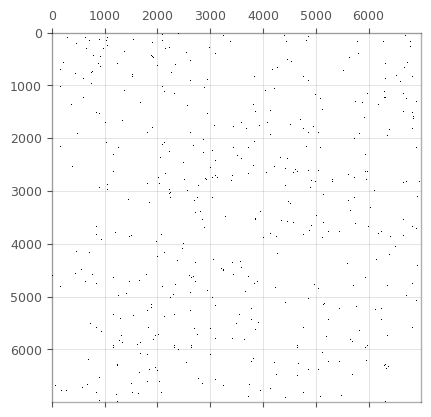

In [16]:
plt.spy(andata_sub.obsp['knn_weights'].toarray())

In [7]:
dist = andata_sub.obsp['knn_distances'].copy()
#dist.data[dist.data == 0] = 0.000001
dist.data = 1 / dist.data

# row normalize the matrix, this makes the matrix dense.
dist /= dist.sum(axis=1)

# convert dist back to sparse matrix
from scipy.sparse import csr_matrix
andata_sub.obsp["knn_weights"] = csr_matrix(dist)

del dist

knn_graph = "knn_weights"

# adata.obsp["knn_connectivities"] represent the edges, while adata.opsp["knn_weights"] represent the weights
andata_sub.obsp["knn_connectivities"] = (andata_sub.obsp[knn_graph] > 0).astype(int)
vp.spatial.set_default_graph(andata_sub, "knn_weights")
vp.spatial.to_spatial_weights(andata_sub, graph_name=knn_graph)

AnnData object with n_obs × n_vars = 7000 × 1500
    obs: 'n_genes_by_counts', 'total_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'total_counts_MT', 'pct_counts_MT', 'log1p_total_counts_MT', 'cell_centroid_x', 'cell_centroid_y', 'cell_area', 'nucleus_centroid_x', 'nucleus_centroid_y', 'nucleus_area', 'z_level', 'nucleus_count', 'cluster'
    var: 'gene_ids', 'feature_types', 'genome', 'MT', 'n_cells_by_counts', 'total_counts', 'mean_counts', 'pct_dropout_by_counts', 'log1p_total_counts', 'log1p_mean_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'config', 'pca', 'knn', 'spatial'
    obsm: 'X_pca', 'X_umap', 'spatial', 'geometry'
    varm: 'PCs'
    layers: 'counts', 'log'
    obsp: 'knn_distances', 'knn_connectivities', 'knn_weights'

In [10]:
qc_features = ["total_counts"]
morans = vp.spatial.moran(andata_sub, qc_features, graph_name=knn_graph)
andata_sub.uns['spatial']['moran'][knn_graph].loc[qc_features, ["I"]]

,I
total_counts,0.001323


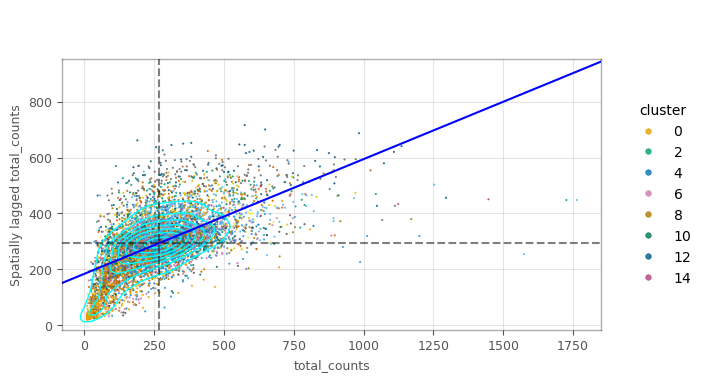

In [11]:
qc_features = ["total_counts"]
vp.spatial.compute_spatial_lag(
    andata_sub,
    qc_features,
    graph_name=knn_graph,
    inplace=True
)
ax = vp.plt.moran_plot(andata_sub, feature="total_counts", color_by='cluster', alpha=0.8,s = 1)

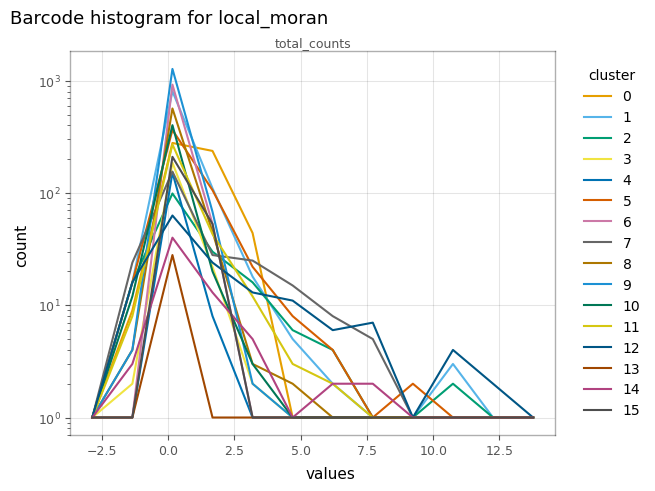

In [12]:
_ = vp.spatial.local_moran(andata_sub, qc_features, graph_name=knn_graph)
axs = vp.plt.plot_barcode_histogram(
    andata_sub,
    qc_features,
    obsm="local_moran",
    color_by='cluster',
    log=True,
    histtype='line',
    bins=10,
)

In [13]:
hvg = andata_sub.var[andata_sub.var['highly_variable'].values].index
andata_sub.X = csr_matrix(andata_sub.X)
vp.spatial.moran(andata_sub, feature=hvg, dim='var', graph_name=knn_graph)
hvgs_moransI = andata_sub.uns['spatial']['moran'][knn_graph].loc[hvg, 'I']
andata_sub.var.loc[hvg, "moran"] = hvgs_moransI

/gpfs/gsfs10/users/kanferg/conda/envs/squidpy-voyagerpy/lib/python3.8/site-packages/esda/moran.py:227: RuntimeWarning: invalid value encountered in double_scalars
  k = k_num / k_den
/gpfs/gsfs10/users/kanferg/conda/envs/squidpy-voyagerpy/lib/python3.8/site-packages/esda/moran.py:238: RuntimeWarning: invalid value encountered in double_scalars
  return self.n / self.w.s0 * inum / self.z2ss
/gpfs/gsfs10/users/kanferg/conda/envs/squidpy-voyagerpy/lib/python3.8/site-packages/esda/moran.py:202: RuntimeWarning: invalid value encountered in true_divide
  self.z /= sy


In [11]:
andata_sub.var.loc[hvg, ["moran"]].sort_values(by='moran')

,moran
NUCB2,-0.008092
ITGB4,-0.008044
CCL19,-0.007861
CNRIP1,-0.007716
IL15RA,-0.007538
...,...
GLRA2,NaN
GTF2A1L,NaN
IGFBP1,NaN
IL1F10,NaN


In [15]:
if andata_sub.var.loc[:, ["moran"]].isna().any(axis=0).any():
    print("True")

True


In [12]:
andata_sub.var.loc[:, ["moran"]] = np.nan_to_num(andata_sub.var.loc[:, ["moran"]],0.0)
andata_sub.var.loc[hvg, ["moran"]].sort_values(by='moran')

,moran
NUCB2,-0.008092
ITGB4,-0.008044
CCL19,-0.007861
CNRIP1,-0.007716
IL15RA,-0.007538
...,...
DEFA1,0.010507
LMO2,0.010990
KCNB1,0.011083
ITGB6,0.015137
